
# Barlow Twins Tutorial

* **Author:** Ananya Harsh Jha
* **License:** CC BY-SA
* **Generated:** 2023-03-15T10:15:32.745667

This notebook describes the self-supervised learning method Barlow Twins.
Barlow Twins differs from other recently proposed algorithms as it doesn't
fall under the category of either contrastive learning, or methods like knowledge
distillation or clustering. The simplicity of the loss function and its effectiveness
in comparison to the current state of the art makes Barlow Twins an interesting
case study.


---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/lightning_examples/barlow-twins.ipynb)

Give us a ⭐ [on Github](https://www.github.com/Lightning-AI/lightning/)
| Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/stable/)
| Join us [on Slack](https://www.pytorchlightning.ai/community)

## Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
! pip install --quiet "setuptools==67.4.0" "ipython[notebook]>=8.0.0, <8.12.0" "pytorch-lightning>=1.4, <2.0.0" "lightning>=2.0.0rc0" "torch>=1.8.1, <1.14.0" "torchmetrics>=0.7, <0.12" "torchvision" "matplotlib"

## Barlow Twins

Barlow Twins finds itself in unique place amongst the current state-of-the-art self-supervised learning methods. It does not fall under the existing categories of contrastive learning, knowledge distillation or clustering based methods. Instead, it creates its own category of redundancy reductionand achieves competitive performance with a simple yet effective loss function. In this tutorial, we look at coding up a small version of Barlow Twins algorithm using PyTorch Lightning.

In [2]:
from functools import partial
from typing import Sequence, Tuple, Union

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as VisionF
from lightning.pytorch.callbacks import Callback, ModelCheckpoint
from torch import Tensor
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import CIFAR10
from torchvision.models.resnet import resnet18
from torchvision.utils import make_grid

batch_size = 32
num_workers = 0  # to run notebook on CPU
max_epochs = 200
z_dim = 128

### Transforms

We first define the data augmentation pipeline used in Barlow Twins. Here, we use pipeline proposed in SimCLR, which generates two copies/views of an input image by applying the following transformations in a sequence.

First it takes a random crop of the image and resizes it to a fixed pre-specified size. Then, it applies a left-to-right random flip with a probability of 0.5. This step is followed by a composition of color jitter, conversion to grayscale with a probability of 0.2 and the application of a Gaussian blur filter. Finally, we normalize the image and convert it to a tensor.

Within this transform, we add a third view for our online finetuner, which we explain later on. But, to explain things quickly here, we add a another transform to perform perform test our encoder on a downstream classification task.

In [3]:
class BarlowTwinsTransform:
    def __init__(self, train=True, input_height=224, gaussian_blur=True, jitter_strength=1.0, normalize=None):
        self.input_height = input_height
        self.gaussian_blur = gaussian_blur
        self.jitter_strength = jitter_strength
        self.normalize = normalize
        self.train = train

        color_jitter = transforms.ColorJitter(
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength,
            0.2 * self.jitter_strength,
        )

        color_transform = [transforms.RandomApply([color_jitter], p=0.8), transforms.RandomGrayscale(p=0.2)]

        if self.gaussian_blur:
            kernel_size = int(0.1 * self.input_height)
            if kernel_size % 2 == 0:
                kernel_size += 1

            color_transform.append(transforms.RandomApply([transforms.GaussianBlur(kernel_size=kernel_size)], p=0.5))

        self.color_transform = transforms.Compose(color_transform)

        if normalize is None:
            self.final_transform = transforms.ToTensor()
        else:
            self.final_transform = transforms.Compose([transforms.ToTensor(), normalize])

        self.transform = transforms.Compose(
            [
                transforms.RandomResizedCrop(self.input_height),
                transforms.RandomHorizontalFlip(p=0.5),
                self.color_transform,
                self.final_transform,
            ]
        )

        self.finetune_transform = None
        if self.train:
            self.finetune_transform = transforms.Compose(
                [
                    transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ]
            )
        else:
            self.finetune_transform = transforms.ToTensor()

    def __call__(self, sample):
        return self.transform(sample), self.transform(sample), self.finetune_transform(sample)

### Dataset

We select CIFAR10 as the dataset to demonstrate the pre-training process for Barlow Twins. CIFAR10 images are 32x32 in size and we do not apply a Gaussian blur transformation on them. In this step, we create the training and validation dataloaders for CIFAR10.

In [4]:
def cifar10_normalization():
    normalize = transforms.Normalize(
        mean=[x / 255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]]
    )
    return normalize


train_transform = BarlowTwinsTransform(
    train=True, input_height=32, gaussian_blur=False, jitter_strength=0.5, normalize=cifar10_normalization()
)
train_dataset = CIFAR10(root=".", train=True, download=True, transform=train_transform)

val_transform = BarlowTwinsTransform(
    train=False, input_height=32, gaussian_blur=False, jitter_strength=0.5, normalize=cifar10_normalization()
)
val_dataset = CIFAR10(root=".", train=False, download=True, transform=train_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .


Files already downloaded and verified


### Plot images

To see how the CIFAR10 images look after the data augmentation pipeline, we load a few images from the dataloader and plot them here.

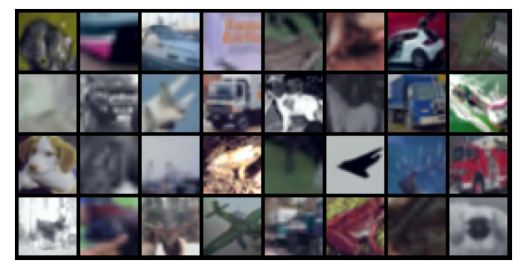

In [5]:
for batch in val_loader:
    (img1, img2, _), label = batch
    break

img_grid = make_grid(img1, normalize=True)


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = VisionF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


show(img_grid)

### Barlow Twins Loss

Here we define the loss function for Barlow Twins. It first normalizes the D dimensinonal vectors from the projection head and then computes the DxD cross-correlation matrix between the normalized vectors of the 2 views of each image.

Then it splits this cross-correlation matrix into two parts. The first part, the diagonal of this matrix is brought closer to 1, which pushes up the cosine similarity between the latent vectors of two views of each image, thus making the backbone invariant to the transformations applied to the views. The second part of the loss pushes the non-diagonal elements of the cross-corrlelation matrix closes to 0. This reduces the redundancy between the different dimensions of the latent vector.

In [6]:
class BarlowTwinsLoss(nn.Module):
    def __init__(self, batch_size, lambda_coeff=5e-3, z_dim=128):
        super().__init__()

        self.z_dim = z_dim
        self.batch_size = batch_size
        self.lambda_coeff = lambda_coeff

    def off_diagonal_ele(self, x):
        # taken from: https://github.com/facebookresearch/barlowtwins/blob/main/main.py
        # return a flattened view of the off-diagonal elements of a square matrix
        n, m = x.shape
        assert n == m
        return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

    def forward(self, z1, z2):
        # N x D, where N is the batch size and D is output dim of projection head
        z1_norm = (z1 - torch.mean(z1, dim=0)) / torch.std(z1, dim=0)
        z2_norm = (z2 - torch.mean(z2, dim=0)) / torch.std(z2, dim=0)

        cross_corr = torch.matmul(z1_norm.T, z2_norm) / self.batch_size

        on_diag = torch.diagonal(cross_corr).add_(-1).pow_(2).sum()
        off_diag = self.off_diagonal_ele(cross_corr).pow_(2).sum()

        return on_diag + self.lambda_coeff * off_diag

### Backbone

This is a standard Resnet backbone that we pre-train using the Barlow Twins method. To accommodate the 32x32 CIFAR10 images, we replace the first 7x7 convolution of the Resnet backbone by a 3x3 filter. We also remove the first Maxpool layer from the network for CIFAR10 images.

In [7]:
encoder = resnet18()

# for CIFAR10, replace the first 7x7 conv with smaller 3x3 conv and remove the first maxpool
encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
encoder.maxpool = nn.MaxPool2d(kernel_size=1, stride=1)

# replace classification fc layer of Resnet to obtain representations from the backbone
encoder.fc = nn.Identity()

### Projection head

Unlike SimCLR and BYOL, the downstream performance of Barlow Twins greatly benefits from having a larger projection head after the backbone network. The paper utilizes a 3 layer MLP with 8192 hidden dimensions and 8192 as the output dimenion of the projection head. For the purposes of the tutorial, we use a smaller projection head. But, it is imperative to mention here that in practice, Barlow Twins needs to be trained using a bigger projection head as it is highly sensitive to its architecture and output dimensionality.

In [8]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=2048, output_dim=128):
        super().__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=True),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim, bias=False),
        )

    def forward(self, x):
        return self.projection_head(x)

### Learning rate warmup

For the purposes of this tutorial, we keep things simple and use a linear warmup schedule with Adam optimizer. In our previous experiments we have found that linear warmup part is much more important for the final performance of a model than the cosine decay component of the schedule.

In [9]:
def fn(warmup_steps, step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    else:
        return 1.0


def linear_warmup_decay(warmup_steps):
    return partial(fn, warmup_steps)

### Barlow Twins Lightning Module

We keep the LightningModule for Barlow Twins neat and simple. It takes in an backbone encoder and initializes the projection head and the loss function. We configure the optimizer and the learning rate scheduler in the ``configure_optimizers`` method.

In [10]:
class BarlowTwins(L.LightningModule):
    def __init__(
        self,
        encoder,
        encoder_out_dim,
        num_training_samples,
        batch_size,
        lambda_coeff=5e-3,
        z_dim=128,
        learning_rate=1e-4,
        warmup_epochs=10,
        max_epochs=200,
    ):
        super().__init__()

        self.encoder = encoder
        self.projection_head = ProjectionHead(input_dim=encoder_out_dim, hidden_dim=encoder_out_dim, output_dim=z_dim)
        self.loss_fn = BarlowTwinsLoss(batch_size=batch_size, lambda_coeff=lambda_coeff, z_dim=z_dim)

        self.learning_rate = learning_rate
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs

        self.train_iters_per_epoch = num_training_samples // batch_size

    def forward(self, x):
        return self.encoder(x)

    def shared_step(self, batch):
        (x1, x2, _), _ = batch

        z1 = self.projection_head(self.encoder(x1))
        z2 = self.projection_head(self.encoder(x2))

        return self.loss_fn(z1, z2)

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch)
        self.log("train_loss", loss, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.shared_step(batch)
        self.log("val_loss", loss, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        warmup_steps = self.train_iters_per_epoch * self.warmup_epochs

        scheduler = {
            "scheduler": torch.optim.lr_scheduler.LambdaLR(
                optimizer,
                linear_warmup_decay(warmup_steps),
            ),
            "interval": "step",
            "frequency": 1,
        }

        return [optimizer], [scheduler]

### Evaluation

We define a callback which appends a linear layer on top of the encoder and trains the classification evaluation head in an online manner. We make sure not to backpropagate the gradients back to the encoder while tuning the linear layer. This technique was used in SimCLR as well and they showed that the final downstream classification peformance is pretty much similar to the results on online finetuning as the training progresses.

In [11]:
class OnlineFineTuner(Callback):
    def __init__(
        self,
        encoder_output_dim: int,
        num_classes: int,
    ) -> None:
        super().__init__()

        self.optimizer: torch.optim.Optimizer

        self.encoder_output_dim = encoder_output_dim
        self.num_classes = num_classes

    def on_fit_start(self, trainer: L.Trainer, pl_module: L.LightningModule) -> None:
        # add linear_eval layer and optimizer
        pl_module.online_finetuner = nn.Linear(self.encoder_output_dim, self.num_classes).to(pl_module.device)
        self.optimizer = torch.optim.Adam(pl_module.online_finetuner.parameters(), lr=1e-4)

    def extract_online_finetuning_view(
        self, batch: Sequence, device: Union[str, torch.device]
    ) -> Tuple[Tensor, Tensor]:
        (_, _, finetune_view), y = batch
        finetune_view = finetune_view.to(device)
        y = y.to(device)

        return finetune_view, y

    def on_train_batch_end(
        self,
        trainer: L.Trainer,
        pl_module: L.LightningModule,
        outputs: Sequence,
        batch: Sequence,
        batch_idx: int,
    ) -> None:
        x, y = self.extract_online_finetuning_view(batch, pl_module.device)

        with torch.no_grad():
            feats = pl_module(x)

        feats = feats.detach()
        preds = pl_module.online_finetuner(feats)
        loss = F.cross_entropy(preds, y)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        acc = accuracy(F.softmax(preds, dim=1), y, task="multiclass", num_classes=10)
        pl_module.log("online_train_acc", acc, on_step=True, on_epoch=False)
        pl_module.log("online_train_loss", loss, on_step=True, on_epoch=False)

    def on_validation_batch_end(
        self,
        trainer: L.Trainer,
        pl_module: L.LightningModule,
        outputs: Sequence,
        batch: Sequence,
        batch_idx: int,
    ) -> None:
        x, y = self.extract_online_finetuning_view(batch, pl_module.device)

        with torch.no_grad():
            feats = pl_module(x)

        feats = feats.detach()
        preds = pl_module.online_finetuner(feats)
        loss = F.cross_entropy(preds, y)

        acc = accuracy(F.softmax(preds, dim=1), y, task="multiclass", num_classes=10)
        pl_module.log("online_val_acc", acc, on_step=False, on_epoch=True, sync_dist=True)
        pl_module.log("online_val_loss", loss, on_step=False, on_epoch=True, sync_dist=True)

Finally, we define the trainer for training the model. We pass in the ``train_loader`` and ``val_loader`` we had initialized earlier to the ``fit`` function.

In [12]:
encoder_out_dim = 512

model = BarlowTwins(
    encoder=encoder,
    encoder_out_dim=encoder_out_dim,
    num_training_samples=len(train_dataset),
    batch_size=batch_size,
    z_dim=z_dim,
)

online_finetuner = OnlineFineTuner(encoder_output_dim=encoder_out_dim, num_classes=10)
checkpoint_callback = ModelCheckpoint(every_n_epochs=100, save_top_k=-1, save_last=True)

trainer = L.Trainer(
    max_epochs=max_epochs,
    accelerator="auto",
    devices=1,
    callbacks=[online_finetuner, checkpoint_callback],
)

# uncomment this to train the model
# this is done for the tutorial so that the notebook compiles
# trainer.fit(model, train_loader, val_loader)

ModelCheckpoint(save_last=True, save_top_k=-1, monitor=None) will duplicate the last checkpoint saved.


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


### Using the trained encoder for downstream tasks

Once the encoder is pretrained on CIFAR10, we can use it to get image embeddings and use them further downstream on tasks like classification, detection, segmentation etc.

In this tutorial, we did not completely train our encoder for 100s of epochs using the Barlow Twins pretraining method. So, we will load the pretrained encoder weights from a checkpoint and show the image embeddings obtained from that.

To create this checkpoint, the encoder was pretrained for 200 epochs, and obtained a online finetune accuracy of x% on CIFAR-10.

In [13]:
# ckpt_model = torch.load('')  # upload checkpoint to aws
# encoder = ckpt_model.encoder
encoder = model.encoder

downstream_dataset = CIFAR10(root=".", train=False, transform=transforms.ToTensor())
dataloader = DataLoader(downstream_dataset, batch_size=4, shuffle=False)

for batch in dataloader:
    img, label = batch
    print(encoder(img).shape)
    break

torch.Size([4, 512])


## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/Lightning-AI/lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Slack](https://www.pytorchlightning.ai/community)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/Lightning-AI/lightning) or [Bolt](https://github.com/Lightning-AI/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/Lightning-AI/lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/Lightning-AI/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

[Pytorch Lightning{height="60px" width="240px"}](https://pytorchlightning.ai)